In [1]:
!pip install -U sentence-transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [4]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [5]:
from fashion_recommendations.metrics.average_precision import mapk
from fashion_recommendations.losses.lambda_loss import lambdaLoss

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        target = target / target.sum()  # Normalise

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [8]:
articles_df = pd.read_csv('data/articles_df_filt.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt.csv')
print(customers.shape)
customers.head()

(43108, 5)


,customer_id,FN,Active,age,customer_id_idx
0,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.0,0.0,0.45,0
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,1.0,1.0,0.44,1
2,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0.0,0.0,0.21,2
3,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,3
4,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0.0,0.0,0.21,4


### Create article EmbeddingBag

In [10]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [11]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [12]:
embeddings = model.encode(article_descriptions)

In [13]:
embeddings = torch.tensor(embeddings)

In [14]:
embeddings.shape

torch.Size([40538, 384])

In [15]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [16]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=512)            
        self.fc_2 = nn.Linear(in_features=512, out_features=256)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=256, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [17]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [18]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=771, out_features=512, bias=True)
  (fc_2): Linear(in_features=512, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [19]:
BATCH_SIZE = 2

In [20]:
total_training_examples = pd.read_csv('data/final_train_set.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

21554.0

In [21]:
total_dev_examples = pd.read_csv('data/final_dev_set.tsv', sep='\t').shape[0]
total_dev_batches = np.ceil(total_dev_examples/BATCH_SIZE)
total_dev_batches

4560.0

In [22]:
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [24]:
MAX_EPOCHS = 1

training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)        
        
        loss = lambdaLoss(y_pred, label, weighing_scheme="lambdaRank_scheme", reduction_log="binary", k=12, reduction='mean')

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = lambdaLoss(y_pred, label, weighing_scheme="lambdaRank_scheme", reduction_log="binary", k=12, reduction='sum')

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
        
    # Compute dev loss:
    
    total_dev_loss = 0
    
    dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(dev_loader, total=total_dev_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            loss = loss = lambdaLoss(y_pred, label, weighing_scheme="lambdaRank_scheme", reduction_log="binary", k=12, reduction='sum')

            total_dev_loss += loss.item()

        mean_dev_loss = total_train_loss / total_dev_examples
        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
        
    fashion_rec_v3.train()

  0%|          | 0/21554.0 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
training_losses[-1], dev_losses[-1]

(1.0693262526218443, 5.054442554607726)

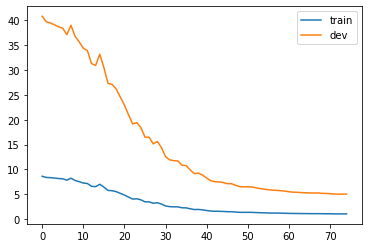

In [ ]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### MAP@12

#### Train

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 43/43.0 [00:11<00:00,  3.73it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([43108, 1000])

In [ ]:
actuals = pd.read_csv('data/final_train_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

43108

In [ ]:
mapk(actuals, predictions.tolist(), 12)

0.988015173275284

🤯

In [ ]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [ ]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.9999808007012001

In [ ]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [ ]:
np.mean(np.array(number_of_positive_examples ) > 0)

1.0

Model is a strong top-1000 candidate generator:
- 99+% precision
- Can use all customers in training set since each has at least 1 positive example 

This could then facilitate a 2-stage approach like YouTube

#### Dev

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_dev_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_dev_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        # predictions.append(y_pred.topk(12, dim=1).indices)
        predictions.append(y_pred.topk(1000, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  3.80it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([9120, 1000])

In [ ]:
actuals = pd.read_csv('data/final_dev_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

9120

In [ ]:
mapk(actuals, predictions.tolist(), 12)

0.052144058243904216

In [ ]:
def precision(a: list, b: list):
    a = set(a)
    b = set(b)
    num_common = len(a.intersection(b))
    return num_common / len(a)

In [ ]:
np.mean(
    [precision(act, pred) for act, pred in zip(actuals, predictions.tolist())]
)

0.3584924604569607

In [ ]:
number_of_positive_examples = [len(set(act).intersection(set(pred))) for act, pred in zip(actuals, predictions.tolist())]

In [ ]:
np.mean(np.array(number_of_positive_examples) > 0)

0.5739035087719299

In a 2-step approach this is the metric we would care about most. 35% is similar to what was achieved with simple heuristic candidate generators but here we also acheive strong MAP!

In [ ]:
actuals_perfect_order = [[i for i in act if i in pred] for act, pred in zip(actuals, predictions.tolist())]

In [ ]:
mapk(actuals_perfect_order, predictions.tolist(), 12)

0.06914616145002658

Interesting! Maximum upside if we perfectly ordered the top-1000 articles in 0.017

#### Test

In [ ]:
total_test_batches = np.ceil(pd.read_csv('data/final_test_set.tsv', sep='\t').shape[0]/BATCH_SIZE)

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_test_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_test_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 9/9.0 [00:02<00:00,  4.03it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([8733, 12])

In [ ]:
actuals = pd.read_csv('data/final_test_set.tsv', sep='\t')['article_id_idx_label'].apply(lambda x: [int(i) for i in x.split(',')]).tolist()
len(actuals)

8733

In [ ]:
mapk(actuals, predictions.tolist(), 12)

0.017464933165907304

In [ ]:
# Number of unique items in predictions
len(predictions.unique())

10063

In [ ]:
# Number of unique items in actuals
len(set([item for sublist in actuals for item in sublist]))

8318

### Submission

In [ ]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

43.0

In [ ]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]


In [ ]:
predictions = torch.concat(predictions)

In [ ]:
predictions.shape

torch.Size([43108, 12])

In [ ]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [ ]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [ ]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0685814001',
 '0685814005',
 '0685814003',
 '0685814033',
 '0685814065',
 '0685814022',
 '0794575017',
 '0685814063',
 '0919499007',
 '0794575001',
 '0456163083',
 '0850917001']

In [ ]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0685814001 0685814005 0685814003 0685814033 0685814065 0685814022 0794575017 0685814063 0919499007 0794575001 0456163083 0850917001'

In [ ]:
submission_set_filt = pd.read_csv('data/final_submission_inputs.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [ ]:
len(predictions_strings)

43108

In [ ]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [ ]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [ ]:
submission_set_filt['prediction_model'] = predictions_strings

In [ ]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [ ]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001 0685814005 0685814003 0685814033 06...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0935858001 0909869004 0888024005 0923134003 05...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001 0910933001 0399223001 0760084015 07...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0904026001 0905914002 0913367001 0574109039 07...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0759814022 0937066001 0806388019 0759814036 08...


In [ ]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [ ]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [ ]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [ ]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [ ]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0809961007 0720125039 0791587015 0896559001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [ ]:
sample_submission.to_csv('data/20220503-fashionrecv3_2.csv', index=False)

In [ ]:
# Top-12 baseline
# sample_submission['prediction'] = '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003'

In [ ]:
# sample_submission.to_csv('submissions/20220502-top12-recent-period.csv', index=False)

- Switching for `BCELoss` to `CrossEntropyLoss` made a HUGE difference
- For the first time we are able to overfit the training set achieving 99% MAP@12!
- Despite this, MAP@12 for the following week (dev set) is 0.05
- MAP@12 is 0.017 for the test set, suggesting that the further ahead we use the model the more performance degrades
- This is potentially why leaderboard performance (week after test) is lower still: 0.0055 (beating top-12 baseline of 0.0046)
- Since the model seems to learn in a stable manner as a next step we will train using the full training set (using last week as labels) to then make predictions for the submission. Hopefully performance on the submission set will then be close to observed dev performance in the model here